# Corrective RAG

Corrective RAG (CRAG) is an advanced technique within RAG, that focuses on improving the accuracy and relevance of generated responses by incorporating mechanism for self-reflection and self-grading of retrieved documents. It does this by evaluating the quality of retrieved documents and applying corrective actions when necessary, such as refining or replacing incorrect retrievals.

Addressing the limitations of Basic RAG:
Traditional RAG systems rely heavily on the accuracy of retrieved documents. If the retrieved information is flawed or incomplete, the generated response can also be inaccurate.

CRAGs core components:
1. Retrieval Evaluator: This component assesses the quality and relevance of retrieved documents.
2. Generative Model: This model generates the initial response based on the retrieved information.
3. Refinement and Corrections: CRAG employs strategies like knowledge refinementor web search to address issues identified by the retrieval evaluator.

Benefits of CRAG:
1. Improved Accuracy: By evaluating and corecting retrieved information, CRAG gelps ensure the accuracy of generated response.
2. Enhanced relevance: CRAG can idintify anf filter out irrelevant information, making the generated response more relevant.
3. Increased robustness: CRAG can handle cases where the initial retrieval process is not perfect, leading to a more robust RAG system.


In [28]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import Field, BaseModel
#from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from typing import List
from typing_extensions import TypedDict
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from IPython.display import Image, display

In [5]:
## Set embeddings

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

## Dos to index
urls = [
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

## lOAD
docs  = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

### Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size =500, chunk_overlap =20
)
doc_splits = text_splitter.split_documents(docs_list)

## Add to vetorstore
vectorestore = FAISS.from_documents(
    documents = doc_splits,
    embedding = OllamaEmbeddings(model="mxbai-embed-large")
)

retriever = vectorestore.as_retriever()


In [34]:
# Data Model
class GradeDocuments(BaseModel):
    """ Binary score for relevance check on retrieved documents."""

    binar_score:str = Field(
        description= "Documents are relevant to the question, 'yes' or 'no'"
    )

## LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeDocuments)

## Prompt
system = """ You are a grader assessing relevance of a retrieved document to a user question. \n
 If the document contins keyword(s) or semantic meaning related to the question, grade it as relevant. \n
 Give a binary score 'yes'or 'no' to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),

    ]
 )

 ## Chain
retrieval_grader = grade_prompt | structured_llm_grader
question= "langchain"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
score = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(score)

binar_score='yes'


In [36]:
score.binar_score

'yes'

In [35]:
score

GradeDocuments(binar_score='yes')

In [12]:
## Generate

## Prompt
from langchain_core.prompts import PromptTemplate
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an expert assistant. Use ONLY the following context to answer.

Context:
{context}

Question:
{question}

Answer in a clear, concise, and helpful way.
""",
)


##LLM
llm = ChatGroq(model="qwen/qwen3-32b")

## post processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## Chain
rag_chain = prompt | llm | StrOutputParser()

## Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

<think>
Okay, let's see. The user asked "langchain" and I need to answer based on the provided context. First, I should look through the documents to find relevant information.

Looking at the context, there are multiple documents from the LangChain tutorials. They mention building a RAG agent, setting up dependencies, using LangSmith for tracing, and components like chat models and embeddings. 

The user's query is just "langchain", which is pretty broad. Since they might be asking about how to get started or key concepts, I should summarize the main points from the context. 

The documents talk about installation steps, setting up LangSmith, selecting components like chat and embeddings models. There's also mention of RAG agents and chains. The answer should cover the basic setup, the three components needed, and the purpose of LangSmith. 

I need to make sure to mention the dependencies installation first, then setting up LangSmith with environment variables. Then, the three compone

In [13]:
## Question re-write
## Prompt

system = """ You are a question re-writer that converts an input quaestion to a better version that is optimized \n
 for web searc. Look at the input and try to reason about the underlying semantic intent/meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})


'<think>\nOkay, let\'s tackle this. The user provided "langchain" as the initial question. That\'s pretty vague. First, I need to understand what they\'re really asking about. LangChain is a framework for developing applications with large language models, right? So maybe they want to know how to use it, best practices, or tutorials.\n\nBut the original query is just "langchain". That\'s not helpful. The user might be looking for an overview, or maybe they want to know how to get started. Since the task is to formulate an improved question for web search, I should make it more specific. Adding keywords like "tutorial", "guide", or "use cases" could help. Also, considering common searches, people often look for how to use LangChain with specific models like GPT or how to build agents. Maybe the user is interested in integrating it with other tools or optimizing performance. \n\nI should also think about the intent. Are they a beginner, looking for resources to learn? Or are they encount

In [15]:
## Web search 
web_search_tool = TavilySearchResults(k=3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18876\1900399387.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [19]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [37]:
## Retrieve
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): new key added to state, documents, that contains retrieved documents
    """
    print("-------- Retrieve --------")
    question = state["question"]

    ## retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New kay added to state, generation, that contains LLM generation
    """
    print("-------- generate ---------")
    question = state["question"]
    documents = state["documents"]

    ## Rag generation
    generation = rag_chain.invoke({"context": documents, "question":question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_document(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("------ Check documents relevance to question-----")
    question = state["question"]
    documents = state["documents"]

    ## Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binar_score
        if grade == "yes":
            print("----Grade: Document relevant----")
            filtered_docs.append(d)
        else:
            print("----- Grade: Document not relevant----")
            web_search = "yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state(dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---- Transform query ----")
    question = state["question"]
    documents = state["documents"]

    ## Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state(dict): The current graph state
    Returns:
        state(dict): Updates documents key with appended web results
    """

    print("------ Web Search--------")
    question = state["question"]
    documents = state["documents"]

    ## Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content = web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

## Edges
def decide_to_generate(state):
    """
    Determines whether to generate an answer or re-generate a question.
    Args:
        state(dict): The cuerrent graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("--- Assess graded documents---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        ## All documents have been filtered check_relevance
        ## We will re-generate a new query
        print(
            "---- Decision: All documents are not relevant to question, transform query----"
        )
        return "transform_query"
    else:
        ## We have relevant documents, so generate answer
        print("----Decision : Generate----")
        return "generate"

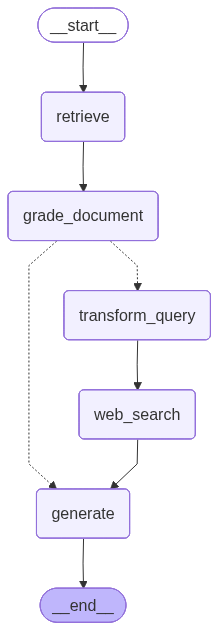

In [38]:
workflow = StateGraph(GraphState)

## define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_document)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search", web_search)

## Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_document")
workflow.add_conditional_edges("grade_document", decide_to_generate,
                               {
                                    "transform_query": "transform_query",
                                    "generate": "generate"
                               },
                               )
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

## Compile
app = workflow.compile()

# Display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
## Invoke App
app.invoke({"question": "what is NLP"})

-------- Retrieve --------
------ Check documents relevance to question-----
----- Grade: Document not relevant----
----- Grade: Document not relevant----
----- Grade: Document not relevant----
----- Grade: Document not relevant----
--- Assess graded documents---
----Decision : Generate----
-------- generate ---------


{'question': 'what in NLP',
 'generation': '<think>\nOkay, the user is asking "what in NLP". Let me check the context provided. Oh, the context is an empty list, so there\'s no prior conversation history to reference. I need to answer based solely on the question.\n\nFirst, "NLP" stands for Natural Language Processing. The user is asking for an explanation of what NLP is. They might be someone new to the field or looking for a quick overview.\n\nI should define NLP clearly and concisely. Mention that it\'s a subfield of AI, computer science, and linguistics. Explain its purpose: enabling computers to process and understand human language. Then list some key applications like machine translation, sentiment analysis, chatbots, text summarization, and speech recognition. Conclude with its use cases in real-world scenarios such as virtual assistants, customer support, and data analysis.\n\nMake sure the answer is straightforward without technical jargon. Avoid using markdown and keep it na